In [67]:
# Picking a training and validation set that minimizes KL-divergence
# of the tag distributions relative the full dataset.
%load_ext autoreload
%autoreload 2
%matplotlib inline
from scipy.stats import entropy
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl

import sys; sys.path.append('..')
from planet.utils.data_utils import tagstr_to_binary, TAGS

print('Done')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


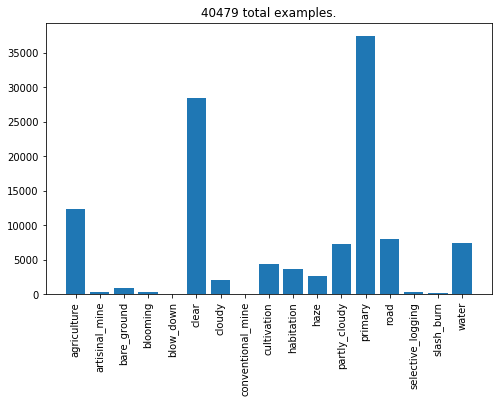

[ 0.30423182  0.00837471  0.02129499  0.00820178  0.00242101  0.70236419
  0.05160701  0.00247042  0.11060056  0.09041725  0.06662714  0.17937696
  0.92672744  0.19938734  0.00839942  0.00516317  0.18308259]
0.0
Done


In [72]:
# Read data and convert text labels to vectors.
df = pd.read_csv('../data/train_v2.csv')
tags_binary = np.vstack([tagstr_to_binary(ts) for ts in df['tags'].values])

# Compute, plot normalized distribution.
dist = np.sum(tags_binary, axis=0)
plt.figure(figsize=(8,5))
plt.bar(np.arange(len(dist)), dist)
plt.xticks(np.arange(len(dist)), TAGS, rotation='vertical')
plt.title('%d total examples.' % df.shape[0])
plt.show()

dist_norm =  dist / tags_binary.shape[0]
print(dist_norm)
print(entropy(dist_norm, dist_norm))
print('Done')

In [71]:
# Randomly sample train/validation sets. 
# Keep the one that minimizes KL-divergence against full distribution.

rng = np.random
rng.seed(333)

prop_trn, prop_val = 0.8, 0.2
min_diff = 1e10
min_idxs = None
min_dists = None
bp = int(df.shape[0]*prop_trn)
idxs = np.arange(df.shape[0])
for _ in tqdm(range(10000)):
    rng.shuffle(idxs)
    idxs_trn, idxs_val = idxs[:bp], idxs[bp:]
    assert set(idxs_trn).intersection(idxs_val) == set([])
    
    dist_trn = np.sum(tags_binary[idxs_trn], axis=0) / len(idxs_trn)
    dist_val = np.sum(tags_binary[idxs_val], axis=0) / len(idxs_val)
    
    diff = abs(entropy(dist_norm, dist_trn)) + abs(entropy(dist_norm, dist_val))
    if diff < min_diff:
        min_diff = diff
        min_idxs = (idxs_trn, idxs_val)
        min_dists = (dist_trn, dist_val) 
    
print('Done: %.7lf' % min_diff)

100%|██████████| 10000/10000 [01:50<00:00, 89.97it/s]

Done: 0.0000400


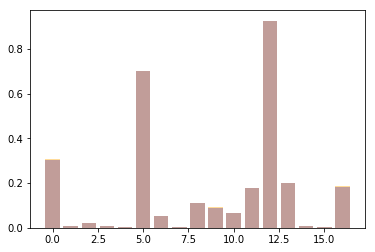

[ -2.15218005e-03   4.32573531e-04  -4.00777704e-04  -2.46783831e-04
  -6.16845148e-05  -1.49141348e-03   7.42704902e-04   7.62855736e-08
  -1.47880729e-03  -3.70276443e-03  -2.44979677e-04   1.11720604e-03
   4.30052293e-04  -1.97013978e-03   1.54657558e-04  -3.07202005e-05
  -5.05860700e-03]


In [69]:
dist_trn, dist_val = min_dists
idxs_trn, idxs_val = min_idxs

plt.bar(range(len(dist_trn)), dist_trn, color='blue', alpha=0.4)
plt.bar(range(len(dist_val)), dist_val, color='orange', alpha=0.4)
plt.show()

print(dist_trn - dist_val)

# Plot and save to disk..
pkl.dump(idxs_trn, open('../data/idxs_trn.pkl', 'wb'))
pkl.dump(idxs_val, open('../data/idxs_val.pkl', 'wb'))